In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date, timedelta
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="final_proj")

def get_day_cases(end_date=date.today()):
    """
    Gets day-by-day case numbers.

    Input: end date (optional)
    Output: array of dataframes, indexed from 0 = 4/12/20
    """
    START_DATE = date(2020, 4, 12)
    GIT_REPO_PATH = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/'
    num_days = (end_date - START_DATE).days
    dfs = []
    for i in range(num_days):
        year, mo, day = (START_DATE + timedelta(days=i)).isoformat().split('-')
        file_name = '{0}-{1}-{2}.csv'.format(mo, day, year)
        dfs.append(pd.read_csv(GIT_REPO_PATH + file_name, error_bad_lines=False))
    return dfs

pd.options.display.max_seq_items = None

Let's start by looking at California's counties.

In [126]:
ca.columns

Index(['Unnamed: 0', 'countyFIPS', 'STATEFP', 'COUNTYFP', 'CountyName',
       'StateName', 'State', 'lat', 'lon', 'POP_LATITUDE', 'POP_LONGITUDE',
       'CensusRegionName', 'CensusDivisionName',
       'Rural-UrbanContinuumCode2013', 'PopulationEstimate2018',
       'PopTotalMale2017', 'PopTotalFemale2017', 'FracMale2017',
       'PopulationEstimate65+2017', 'PopulationDensityperSqMile2010',
       'CensusPopulation2010', 'MedianAge2010', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', 'RespMortalityRate2014', '#FTEHospitalTotal2017',
       'TotalM.D.'s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale

In [4]:
counties = pd.read_csv('covid19/small_abridged.csv')

cases = pd.read_csv('county_info_cases_deaths.csv')
county_unique_columns = []
for i in counties.columns:
    if i not in cases.columns:
        county_unique_columns += [i]
county_unique_columns += ['CountyName']
cases_info = cases.merge(counties[county_unique_columns], how='left', on='CountyName')
ca = cases_info.loc[cases_info['StateName'] == 'CA']
ca

,Unnamed: 0,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,...,Chlamydia Rate,Teen Birth Rate,Preventable Hospitalization Rate,% Vaccinated,Violent Crime Rate,Injury Death Rate,Average Daily PM2.5,Presence of Water Violation,% Drive Alone to Work,% Long Commute - Drives Alone
1034,180,6001,6.0,1.0,Alameda,CA,California,37.646537,-121.849494,37.705201,...,553.2,11.408149,3298.0,44.0,628.781962,42.021286,10.4,0.0,61.489237,46.4
1035,181,6003,6.0,3.0,Alpine,CA,California,38.595405,-119.817665,38.728298,...,803.6,NaN,2480.0,21.0,442.477876,217.470098,5.6,0.0,66.011236,35.3
1036,182,6005,6.0,5.0,Amador,CA,California,38.452565,-120.640865,38.394208,...,170.9,18.101093,3115.0,46.0,237.070738,97.813731,8.9,0.0,80.634378,41.4
1037,183,6007,6.0,7.0,Butte,CA,California,39.667234,-121.600771,39.669037,...,527.3,17.643410,4656.0,39.0,327.057309,98.235283,8.9,1.0,75.287737,24.1
1038,183,6007,6.0,7.0,Butte,CA,California,39.667234,-121.600771,39.669037,...,153.7,NaN,2548.0,27.0,138.861337,93.479785,5.8,0.0,76.373057,23.8
1039,183,6007,6.0,7.0,Butte,CA,California,39.667234,-121.600771,39.669037,...,405.7,33.034450,2418.0,32.0,154.723915,64.560305,5.1,0.0,72.464367,23.0
1040,184,6009,6.0,9.0,Calaveras,CA,California,38.209207,-120.553016,38.163627,...,166.4,13.728587,3050.0,40.0,327.245738,94.734279,9.0,0.0,75.588288,60.4
1041,185,6011,6.0,11.0,Colusa,CA,California,39.182700,-122.241495,39.156148,...,224.7,29.632480,3534.0,43.0,200.958056,76.908109,8.7,1.0,76.954164,32.6
1042,186,6013,6.0,13.0,Contra Costa,CA,California,37.918611,-121.916679,37.935588,...,499.5,11.398001,3379.0,45.0,336.027791,45.954189,11.6,1.0,67.597633,51.0
1043,187,6015,6.0,15.0,Del Norte,CA,California,41.760269,-123.903650,41.791232,...,364.0,42.469524,2869.0,36.0,609.109201,103.420148,8.5,0.0,73.778617,10.0


For our project, we are examining the relationship between a county's SVI score and COVID-19's impact on that county, in terms of case rate and death rate. First we'll examine cases.

In [9]:
cases_columns, death_columns = [], []
for i in ca.columns:
    if 'cases' in i:
        cases_columns += [i]
    elif 'death' in i:
        death_columns += [i]
svi_columns = ['SVIPercentileSEtheme', 'SVIPercentileHDtheme', 
                  'SVIPercentileMLtheme', 'SVIPercentileHTtheme']
svi_columns = ca[svi_columns]
svi_mean = svi_columns.mean(axis=1)
cases_only = ca[cases_columns].copy()
cases_only['pop'] = ca['PopulationEstimate65+2017'].copy()
cases_only['mean_svi'] = ca['SVIPercentile'].copy()
cases_only
deaths_only = ca[death_columns].copy()
deaths_only.loc['pop'] = ca['PopulationEstimate65+2017'].copy()
deaths_only['mean_svi'] = ca['SVIPercentile'].copy()

def plot_svi_bins(df=cases_only, num_bins=4, cases=True):
    bins = list(np.arange(0,  1+(1/num_bins), 1/num_bins))
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    for i in range(num_bins):
        binned = df.loc[df['mean_svi'] > bins[i]]
        binned = df.loc[df['mean_svi'] < bins[i+1]]
        binned = binned.sum(axis=0)[:-1]
        binned = binned / binned[-1]
        binned = binned[:-1]
        if cases:
            binned.index = pd.to_datetime(binned.index.str.replace('_cases', ''))
        else:
            binned.index = pd.to_datetime(binned.index.str.replace('_deaths', ''))
        sns.lineplot(x = binned.index, y = binned.values, ax=ax, label = str(bins[i]) + '-' + str(bins[i+1]))
    plt.xlabel('Time')
    if cases:
        plt.ylabel('Case Rate (per person)')
        plt.title('Case Rate Over Time')
    else:
        plt.ylabel('Death Rate (per person)')
        plt.title('Death Rate Over Time')
    plt.setp(ax.get_xticklabels(), rotation=60)
    ax.legend()
    plt.legend(title = "SVI Percentile")
    plt.show()

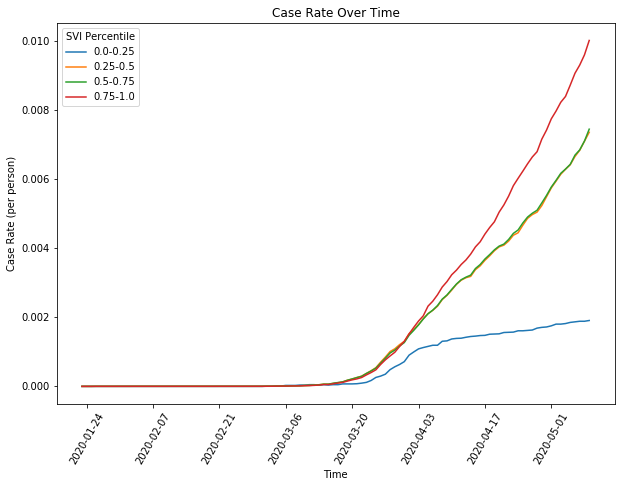

In [10]:
plot_svi_bins()

Unsurprisingly, we see that counties with the highest social vulnerability have the steepest cases curve. There is a surprising flat plateau to the counties with the lowest social vulnerability. The following cell shows the death rates.

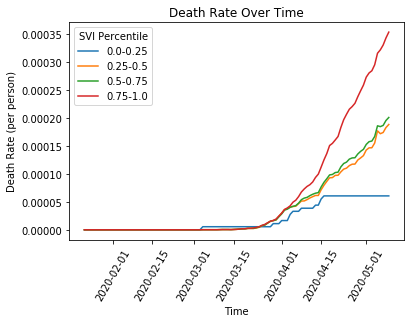

In [148]:
plot_svi_bins(df=deaths_only, cases=False)

Once again we see that the least vulnerable counties, understandably, have had the smallest impact from covid.
Now we'll examine which factors of SVI have the largest impact on COVID's case and death rate among counties.